In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig as bw
import h5py
from scipy.stats import beta

import sys
sys.path.insert(0, '/home/jbreda/PROseq/scripts/Phase_to_LabColor')
from phase_to_labcolor import phase_to_labcolor as p2lc
sys.path.insert(0, '/home/jbreda/PROseq/scripts/FourierTransform')
from fourier_transform import fourier_transform

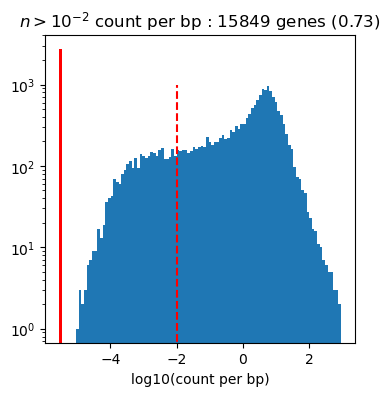

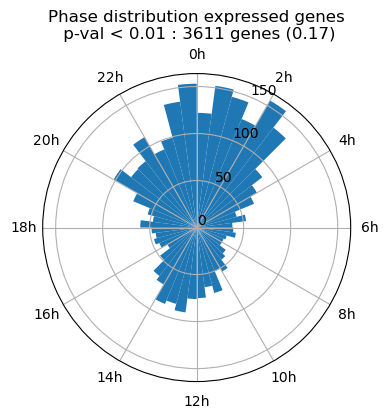

In [35]:
gene_phase_amp = pd.read_csv('../results/phase_amp/gene_phase_amp.csv',sep='\t')

# remove unexpressed genes
th = 1e-2
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.hist(np.log10(gene_phase_amp.loc[gene_phase_amp.mean_count_per_bp>0,'mean_count_per_bp']),bins=100)
ax.bar(-5.5,(gene_phase_amp.mean_count_per_bp<=0).sum(),width=.1,color='r')
ax.plot([np.log10(th),np.log10(th)],[0,1000],'r--')
ax.set_yscale('log')
ax.set_title(r'$n > 10^{-2}$' + f' count per bp : {(gene_phase_amp.mean_count_per_bp>th).sum()} genes ({(gene_phase_amp.mean_count_per_bp>th).sum()/gene_phase_amp.shape[0]:.2f})')
ax.set_xlabel('log10(count per bp)')
fig.savefig('fig/phase_amp/hist_mean_count_per_bp.pdf',bbox_inches='tight')

# print 10 highest mean count per bp genes under the threshold:
idx_in = gene_phase_amp.loc[(gene_phase_amp.mean_count_per_bp > th) & (gene_phase_amp.pval < 0.01)  ].index
#gene_phase_amp.drop(idx_out,inplace=True)

fig, ax = plt.subplots(1,1,figsize=(4,4),subplot_kw=dict(projection='polar'))
h, bin = np.histogram(gene_phase_amp.loc[idx_in,'phase'],bins=np.linspace(0,2*np.pi,49,endpoint=True))
bin = (bin[:-1] + bin[1:])/2
ax.bar(bin,h,width=2*np.pi/len(bin),align='center')

ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
ax.set_yticks(np.arange(0,200,50))
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_title(f'Phase distribution expressed genes\n p-val < 0.01 : {idx_in.shape[0]} genes ({idx_in.shape[0]/gene_phase_amp.shape[0]:.2f})') 
fig.savefig('fig/phase_amp/hist_gene_phase.pdf',bbox_inches='tight')

6553

Frac. out 0.26736929690750244


Text(0.5, 0, 'log10(length)')

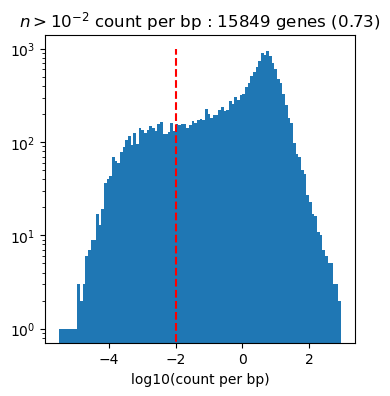

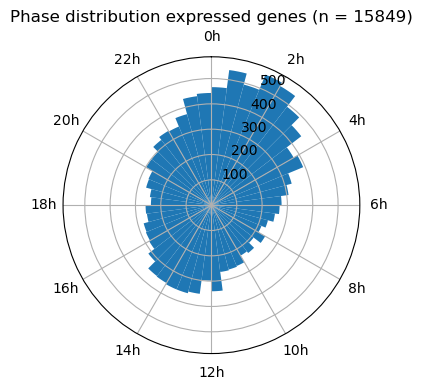

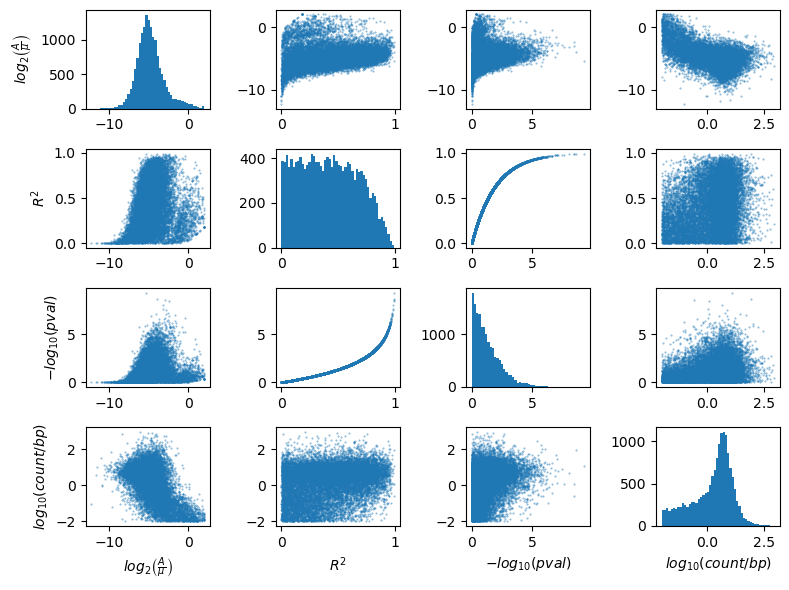

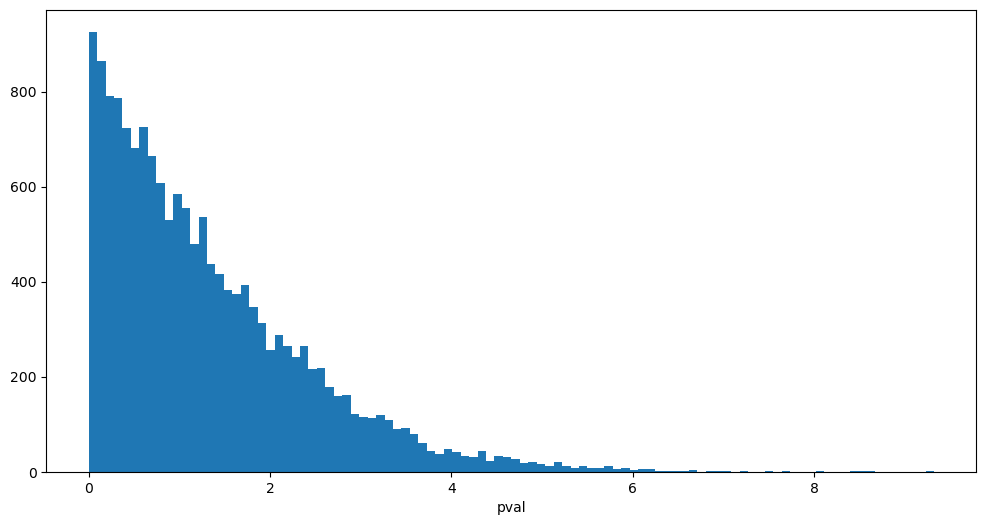

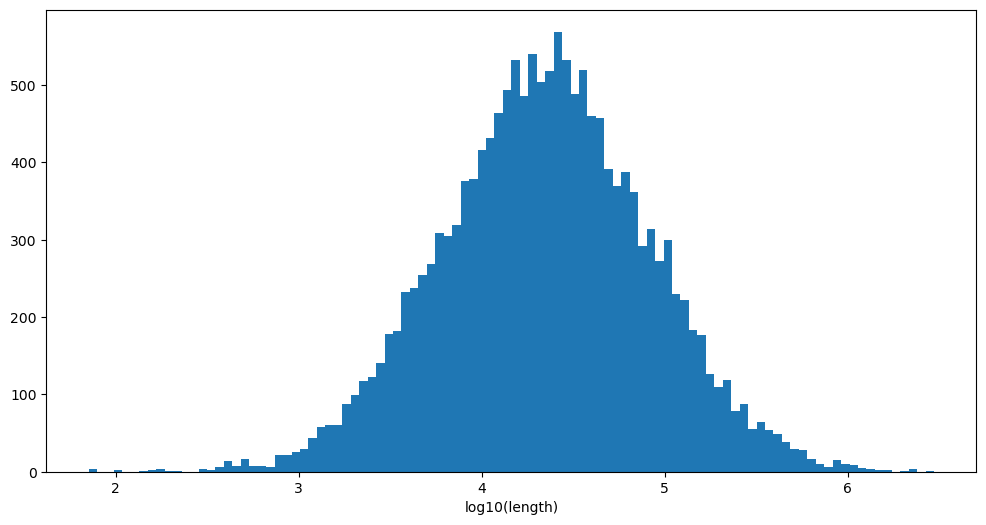

In [4]:






gene_phase_amp['rel_amp'] = np.log2(gene_phase_amp.amplitude/gene_phase_amp.mean_log_expression)
gene_phase_amp['mean_count_per_bp'] = np.log10(gene_phase_amp.mean_count_per_bp)
gene_phase_amp['pval'] = -np.log10(gene_phase_amp.pval)


vars_to_label = {'rel_amp':r'$log_2 \left( \frac{A}{\mu} \right)$',
                 'R2':r'$R^2$',
                 'pval':r'$-log_{10}(pval)$',
                'mean_count_per_bp':r'$log_{10}(count/bp)$'}
n_vars = len(vars_to_label)

# scatter plot with every pair of variables
fig, axes = plt.subplots(n_vars, n_vars, figsize=(8,6))
for i, var1 in enumerate(vars_to_label.keys()):
    for j, var2 in enumerate(vars_to_label.keys()):
        ax = axes[i,j]
        if i==j:
            ax.hist(gene_phase_amp[var1],bins=50)
        else:
            ax.scatter(gene_phase_amp[var2],gene_phase_amp[var1],marker='.',s=1,alpha=.5)
        
        if i==(n_vars-1):
            ax.set_xlabel(vars_to_label[var2])
        if j==0:
            ax.set_ylabel(vars_to_label[var1])
fig.tight_layout()


fig, axes = plt.subplots(1,1,figsize=(12,6))
axes.hist(gene_phase_amp.pval,bins=100)
axes.set_xlabel('pval')

gene_phase_amp['length'] = np.log10(gene_phase_amp.end - gene_phase_amp.start)

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.hist(gene_phase_amp.length,bins=100)
ax.set_xlabel('log10(length)')
#ax.set_xscale('log')

# Gene antisense transcription

In [4]:
def get_data(coord, bw_folder, bin_size):

    T = np.arange(0,48,4)
    Samples = [f'CT{t:02d}' for t in T]
    #sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001' # Run1
    strand_dict = {'+': 'forward', '-': 'reverse'}
    [chr,start,end,strand] = coord.split(':')

    # get bigwig data to dataframe
    df = pd.DataFrame(columns=['start','end'])
    for sample in Samples:
        fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
        with bw.open(fin,'r') as bw_file:
            df_t = pd.DataFrame(bw_file.intervals(chr,int(start),int(end)),columns=['start','end',sample])
        df = pd.merge(df,df_t,on=['start','end'],how='outer')
    df['position'] = (df.start + bin_size/2).astype(int)
    df.sort_values('position',inplace=True)

    # get measurments matrix (time x position)
    measurements = df.loc[:,Samples].values.T.astype(float) # time x position
    measurements[np.isnan(measurements)] = 0
    measurements = np.log2(measurements+1)

    positions = df.position.values
    
    return measurements, positions


/home/jbreda/miniforge3/envs/pro-seq/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


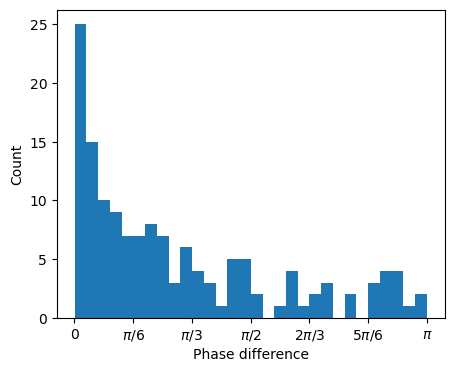

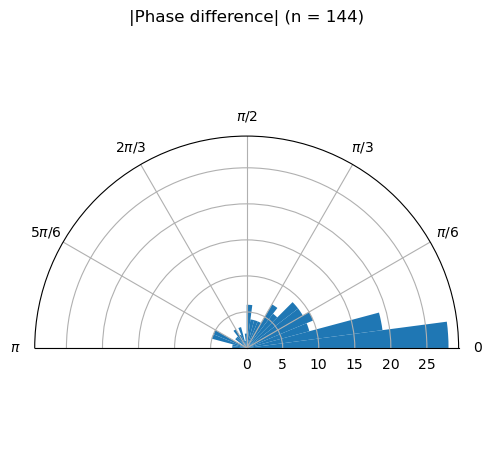

In [5]:

# get results from kalman filter
bin_size = 1000
infile_kalman_on_genes = f'../results/kalman/Gene_Q_1e-5/Kalman_Smoothing_{bin_size}bp.hdf5'
#hf = h5py.File(infile_kalman_on_genes, 'r')
with h5py.File(infile_kalman_on_genes, 'r') as hf:
    Genes = list(hf.keys())
    Genes.remove('K')
    Genes = np.array(Genes)
    adjR2 = np.zeros([len(Genes),2])
    strand = np.zeros(len(Genes),dtype=int)
    for g, gene in enumerate(Genes):
        adjR2[g,0] = hf[gene].attrs['adjR2_fourier']
        adjR2[g,1] = hf[gene].attrs['adjR2_kf']
df = pd.DataFrame(adjR2,columns = ['adjR2_f','adjR2_kf'])
df.loc[:,'gene_id'] = Genes


gene_phase_amp = pd.read_csv('../results/phase_amp/gene_phase_amp.csv',sep='\t')
gene_antisense_phase_amp = pd.read_csv('../results/phase_amp/gene_antisense_phase_amp.csv',sep='\t')
assert np.all(gene_phase_amp.gene_id == gene_antisense_phase_amp.gene_id)
# merge sense and antisense data
gene_phase_amp = pd.merge(gene_phase_amp,gene_antisense_phase_amp,on=['chr','start','end','strand','gene_name','gene_id'],suffixes=('','_as'))
# add adjR2 from kalman
gene_phase_amp = pd.merge(gene_phase_amp,df,on='gene_id',how='left')
gene_phase_amp.set_index('gene_name',inplace=True)

gene_phase_amp.loc[:,'as_log2fc_mean_count_per_bp'] = np.log2( gene_phase_amp.mean_count_per_bp_as / gene_phase_amp.mean_count_per_bp )
gene_phase_amp.loc[:,'phase_diff'] =  np.abs( (gene_phase_amp.phase_as - gene_phase_amp.phase + np.pi) % (2*np.pi) - np.pi )

idx = (gene_phase_amp.R2 > 0.5) & (gene_phase_amp.R2_as > 0.5) & (gene_phase_amp.as_log2fc_mean_count_per_bp > -5) & (gene_phase_amp.end - gene_phase_amp.start > 20000) & (gene_phase_amp.adjR2_kf > 0.3)
gene_phase_amp = gene_phase_amp.loc[idx]

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.hist(gene_phase_amp.phase_diff,bins=30)
ax.set_xticks(np.linspace(0,np.pi,7,endpoint=True),labels=['0','$\pi/6$', '$\pi/3$', '$\pi/2$', '$2\pi/3$', '$5\pi/6$', '$\pi$'])
ax.set_xlabel('Phase difference')
ax.set_ylabel('Count')



fig, ax = plt.subplots(1,1,figsize=(5,5),subplot_kw=dict(projection='polar'))
h, bin = np.histogram(gene_phase_amp.phase_diff,bins=np.linspace(0,2*np.pi,49,endpoint=True))
bin = (bin[:-1] + bin[1:])/2
ax.bar(bin,h,width=2*np.pi/len(bin),align='center')

ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False))
ax.set_xlim(0,np.pi)
ax.set_xticks(np.linspace(0,np.pi,7,endpoint=True),labels=['0','$\pi/6$', '$\pi/3$', '$\pi/2$', '$2\pi/3$', '$5\pi/6$', '$\pi$'])
#ax.set_theta_zero_location("N")  # theta=0 at the top
#ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_title(f'|Phase difference| (n = {gene_phase_amp.shape[0]})')
fig.tight_layout()
fig.savefig('fig/phase_amp/gene_sense_antisense_phase_diff_hist.pdf')

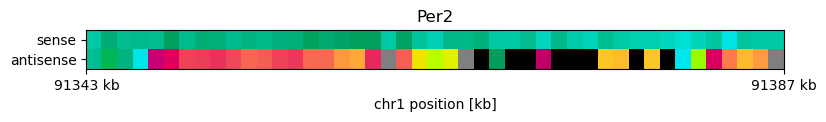

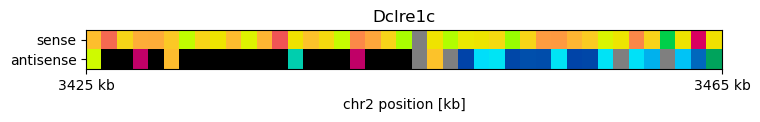

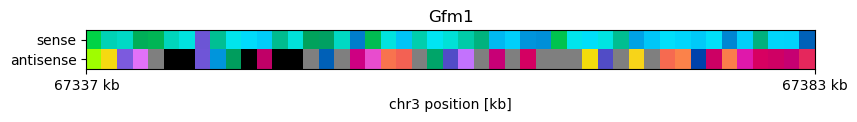

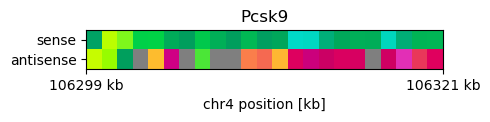

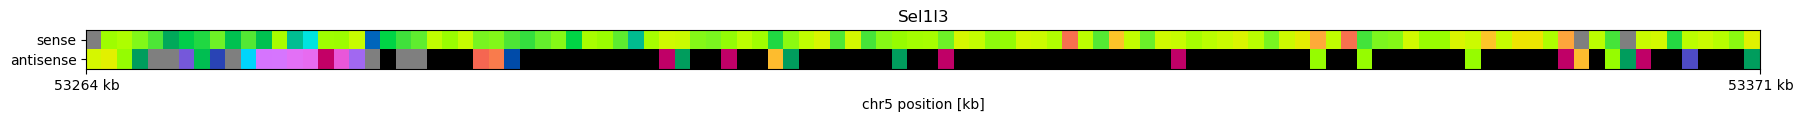

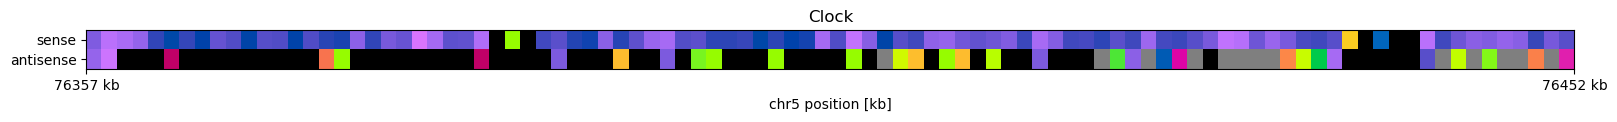

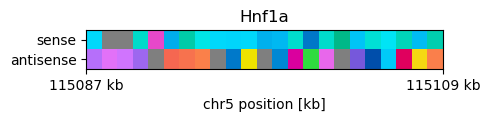

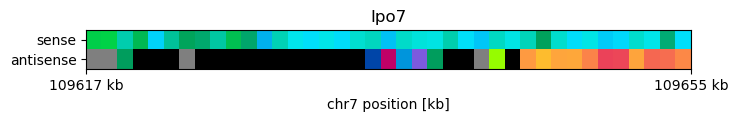

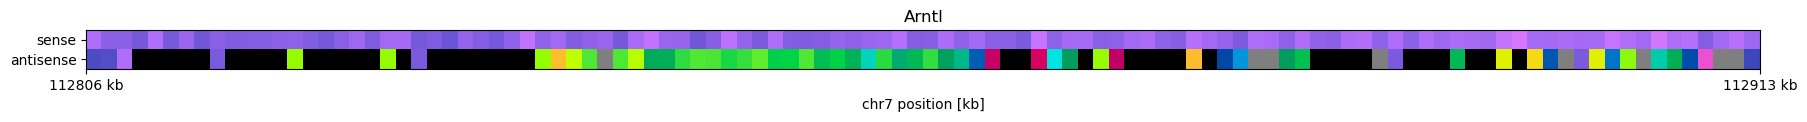

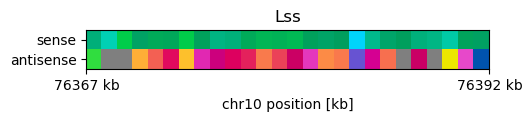

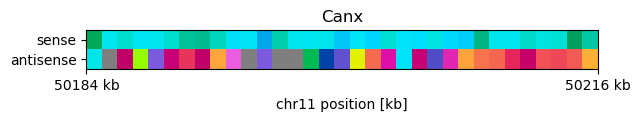

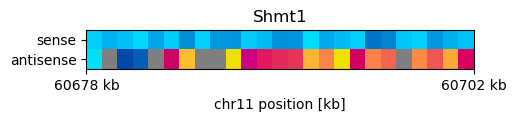

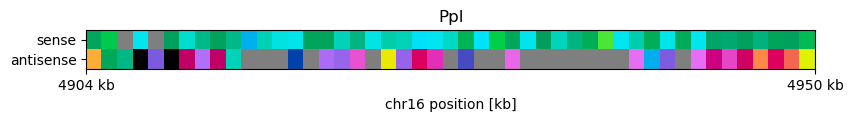

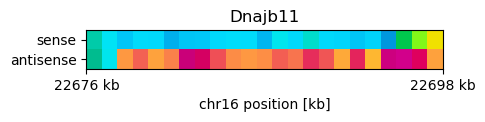

In [6]:
idx_antisense = gene_phase_amp.phase_diff > 5/6*np.pi

for gene in gene_phase_amp.loc[idx_antisense].index:
    coord = gene_phase_amp.loc[gene,['chr','start','end','strand']].values
    if coord[3] == '+':
        f = bw.open('../results/phase_amp/bin_phase_amp_forward_1000bp.bb')
        f_as = bw.open('../results/phase_amp/bin_phase_amp_reverse_1000bp.bb')
    else:
        f = bw.open('../results/phase_amp/bin_phase_amp_reverse_1000bp.bb')
        f_as = bw.open('../results/phase_amp/bin_phase_amp_forward_1000bp.bb')

    entries = np.array( f.entries(coord[0],int(coord[1]),int(coord[2])) )
    idx = np.array( [e[2].split('\t')[0].split('|')[0] != 'no_read' for e in entries] )
    entries = entries[idx,:]
    R2 = np.array( [e[2].split('\t')[1] for e in entries] ).astype(int)/1e3
    phase_col = np.array( [e[2].split('\t')[5].split(',') for e in entries] ).astype(int)/255
    f.close()

    entries_as = np.array( f_as.entries(coord[0],int(coord[1]),int(coord[2])) )
    idx = np.array( [e[2].split('\t')[0].split('|')[0] != 'no_read' for e in entries_as] )
    entries_as = entries_as[idx,:]
    R2_as = np.array( [e[2].split('\t')[1] for e in entries_as] ).astype(int)/1e3
    phase_col_as = np.array( [e[2].split('\t')[5].split(',') for e in entries_as] ).astype(int)/255
    f_as.close()

    x = np.array([e[:2] for e in entries]).astype(int).mean(1)/1e3
    x_as = np.array([e[:2] for e in entries_as]).astype(int).mean(1)/1e3

    #fig, ax = plt.subplots(1,1,figsize=(12,1))
    #ax.scatter(x,y,s=np.sqrt(100*R2),c=phase_col)
    #ax.scatter(x_as,y_as,s=np.sqrt(100*R2_as),c=phase_col_as)

    X = np.arange(np.concatenate([x,x_as]).min(), np.concatenate([x,x_as]).max()+1, 1)
    # plot phase per bin
    Φ = np.zeros((2,len(X),3))
    Φ[0,np.where(x[:,None] == X)[1],:] = phase_col
    Φ[1,np.where(x_as[:,None] == X)[1],:] = phase_col_as

    if coord[3] == '-':
        Φ = Φ[:,::-1,:]

    fig, ax = plt.subplots(1,1,figsize=(.2*X.shape[0],.5))
    ax.imshow(Φ,aspect='auto',interpolation='none')
    ax.set_title(gene)
    ax.set_yticks([0,1])
    ax.set_yticklabels(['sense','antisense'])
    ax.set_xticks([-.5,X.shape[0]-.5])
    ax.set_xticklabels([f'{int(X[0]//1)} kb',f'{int(X[-1]+.5//1)} kb'])
    ax.set_xlabel(f'{coord[0]} position [kb]')

    fig.savefig(f'fig/phase_amp/sense_antisense_phase/{gene}.pdf',bbox_inches='tight')






    

In [6]:
N = [145319818,122398630,240217397,206562598,176461022,146340417,191665948,156152288,142947897,119763909,129746611,110371493,201097556,174039332,235574816,197016339,239503268,201764495,190822179,155899175,141577437,118063258,214498573,186876316]
len(N)
print(sum(N)/12 *1e-6)

345.39006433333327


# Shape along gene

In [ ]:
def get_data(coord, bw_folder, bin_size):

    T = np.arange(0,48,4)
    Samples = [f'CT{t:02d}' for t in T]
    #sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001' # Run1
    strand_dict = {'+': 'forward', '-': 'reverse'}
    [chr,start,end,strand] = coord.split(':')

    # get bigwig data to dataframe
    df = pd.DataFrame(columns=['start','end'])
    for sample in Samples:
        fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
        with bw.open(fin,'r') as bw_file:
            df_t = pd.DataFrame(bw_file.intervals(chr,int(start),int(end)),columns=['start','end',sample])
        df = pd.merge(df,df_t,on=['start','end'],how='outer')
    df['position'] = (df.start + bin_size/2).astype(int)
    df.sort_values('position',inplace=True)

    # get measurments matrix (time x position)
    measurements = df.loc[:,Samples].values.T.astype(float) # time x position
    measurements[np.isnan(measurements)] = 0
    measurements = np.log2(measurements+1)

    positions = df.position.values
    
    return measurements, positions

In [94]:
gene_phase_amp = pd.read_csv('../results/phase_amp/gene_phase_amp.csv',sep='\t')
my_gene = 'Wwox'
coord = ':'.join( [str(c) for c in gene_phase_amp.loc[gene_phase_amp.gene_name == my_gene,'chr':'strand'].values[0]] ) 
gene_id = gene_phase_amp.loc[gene_phase_amp.gene_name == my_gene,'gene_id'].values[0]

# get data
bw_folder = '../results/binned_norm_coverage'
bin_size = 10000
X, position = get_data(coord, bw_folder, bin_size)

# get results from kalman filter
#infile_kalman_on_genes = f'../results/kalman/Gene_Q_1e-5/Kalman_Smoothing_{bin_size}bp.hdf5'
#hf = h5py.File(infile_kalman_on_genes, 'r')
#with h5py.File(infile_kalman_on_genes, 'r') as hf:
#    X = hf[gene_id]['measurements'][:] # time x position
#    pos = hf[gene_id]['positions'][:]
#    smoothed = hf[gene_id]['smoothed'][:]
#    R2 = hf[gene_id]['R2'][:]
#    mu = hf[gene_id]['mu'][:]
#    Sigma = hf[gene_id]['Sigma'][:]
#    LL = hf[gene_id]['LL'][:]

T = np.arange(0,48,4)
ω = 2*np.pi / 24
N = X.shape[0]
m = X.shape[1]
f_n = np.sum(X*np.exp(-1j*ω*T[:,None]),0)
a_n = 4/N * np.abs(f_n)
φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
φ_n[φ_n<0] += np.pi * 2
μ = 1/N * np.sum(X,0)

x_hat = μ[None,:] + 0.5 * a_n[None,:] * np.cos(ω * T[:,None] - φ_n[None,:])
sig2_res = np.var(X - x_hat,1)
sig2_tot = np.var(X,1)
R2 = np.zeros(sig2_res.shape)
R2[sig2_tot==0] = 0
R2[sig2_tot!=0] = 1 - sig2_res[sig2_tot!=0] / sig2_tot[sig2_tot!=0]
p = 3
pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)

a_1 = np.ones(m)
x = 0.5 * a_1[None,:] * np.cos(ω * T[:,None] - φ_n[None,:])

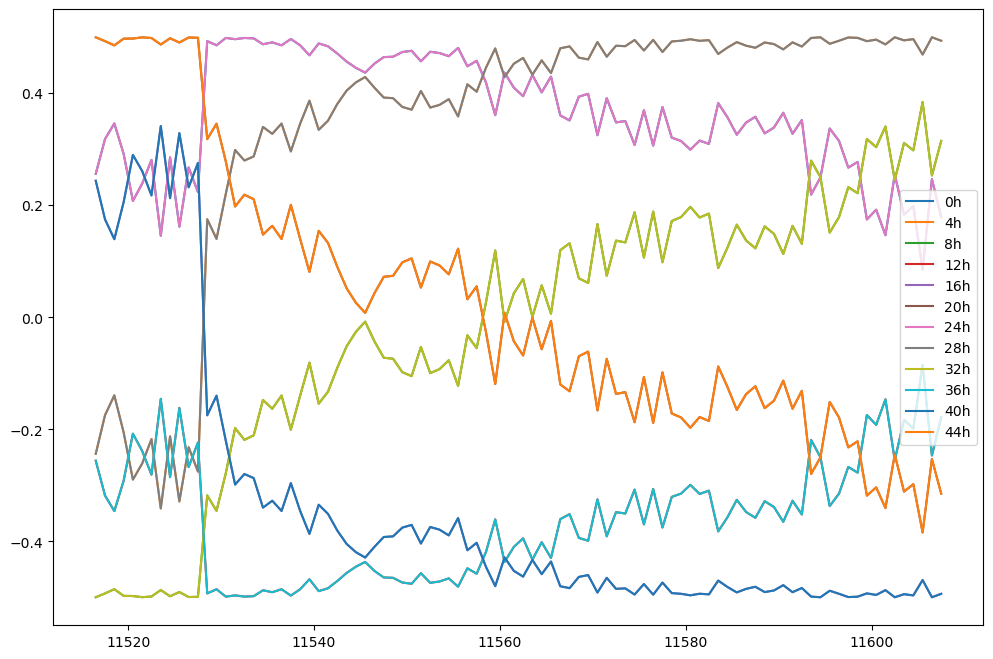

In [96]:
T = np.arange(0,48,4)
fig, ax = plt.subplots(1,1,figsize=(12,8))
for t in range(T.shape[0]):
    ax.plot(position/bin_size,x[t,:],label=f'{T[t]}h')
ax.legend()

In [97]:
x

array([[ 0.25615318,  0.31832935,  0.34611933, ...,  0.0849036 ,
         0.24686013,  0.17884355],
       [-0.24379592, -0.17475121, -0.13943202, ...,  0.46917599,
         0.49998691,  0.493787  ],
       [-0.4999491 , -0.49308056, -0.48555135, ...,  0.38427239,
         0.25312678,  0.31494346],
       ...,
       [-0.25615318, -0.31832935, -0.34611933, ..., -0.0849036 ,
        -0.24686013, -0.17884355],
       [ 0.24379592,  0.17475121,  0.13943202, ..., -0.46917599,
        -0.49998691, -0.493787  ],
       [ 0.4999491 ,  0.49308056,  0.48555135, ..., -0.38427239,
        -0.25312678, -0.31494346]])

In [83]:
a_n

array([0.25196722, 0.84289906, 0.57854903, 0.54785253, 0.28875829,
       0.58626227, 1.29073356, 1.01918854, 0.39210098, 0.37999482,
       0.60055655, 1.24034697, 1.80149199, 0.81224386, 0.97449339,
       0.82598318, 1.14207079, 1.25981041, 0.35389845, 1.17200477,
       0.40579235, 0.35798791, 1.24921745, 0.63168781, 1.39282324,
       0.17111538, 0.43747558, 0.59469849, 1.17015012, 0.60369784,
       0.65454133, 1.08489638, 1.12416259, 1.50370421, 0.97065174,
       1.48277063, 1.25238411, 0.57796146, 2.21202926, 0.65025517,
       0.27664974, 2.11407793, 2.36191074, 2.01307266, 0.95739427,
       1.24805397, 1.519578  , 1.34007151, 1.02534606, 1.35528686,
       3.19809927, 1.95656221, 2.76332614, 0.98169601, 0.82419082,
       0.46315701, 1.60167938, 1.80104201, 1.12728947, 2.3832388 ,
       0.86162176, 1.22542405, 0.19457312, 0.20337325, 0.78246518,
       0.29254414, 1.14009765, 0.67972917, 1.04087079, 1.23565701,
       0.90179114, 0.91468394, 0.66371659, 0.79736561, 1.00536

array([[3.46988687, 5.10189493],
       [3.47687424, 5.09786526],
       [3.48385227, 5.09382098],
       [3.49082045, 5.0897628 ],
       [3.49778272, 5.08569425],
       [3.50473294, 5.08161586],
       [3.51168098, 5.07752821],
       [3.5186197 , 5.07343034],
       [3.52555411, 5.06931279],
       [3.53248193, 5.06518506],
       [3.5394023 , 5.0610467 ],
       [3.54631391, 5.05689177],
       [3.55321778, 5.0527209 ],
       [3.56011275, 5.04853387],
       [3.56700267, 5.0443391 ],
       [3.5738836 , 5.04012798],
       [3.58076033, 5.03589849],
       [3.58762716, 5.03164976],
       [3.59448389, 5.02738636],
       [3.60133538, 5.02310744],
       [3.60817784, 5.01881772],
       [3.61501215, 5.0145191 ],
       [3.62184309, 5.01020682],
       [3.62866632, 5.00587952],
       [3.63548864, 5.00153898],
       [3.64230031, 4.99718218],
       [3.64910659, 4.99281245],
       [3.65591256, 4.98842899],
       [3.66270801, 4.98402659],
       [3.66949165, 4.97961351],
       [3.

In [38]:
hf[gene_id].keys()

<KeysViewHDF5 ['LL', 'R2', 'Sigma', 'measurements', 'mu', 'positions', 'smoothed']>